In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import csv
import os
import time

np.random.seed(1234)

In [4]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce GTX 1650


In [5]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")
    print("CPU")

CUDA


In [6]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [34]:
lbfgs_lr = 0.1
adam_lr = 0.01

w_pde = 1
w_bc = 1

In [44]:
class PINN():
    def __init__(self, X, layers, lb, rb, q_c):
        
        self.x = torch.tensor(X, requires_grad=True).float().to(device)
        print(self.x)
        self.q_c = torch.tensor(q_c).float().to(device)

        self.lb = lb
        self.rb = rb

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        self.iter = 0
        self.loss_count = 0

    def model_value(self, x):
        u = self.dnn(x)
        return u
    
    def boundary_condition(self, cond, u, u_x, u_2x, u_3x):
        bc_loss = 0

        match cond:
            case 'pinned':
                bc_loss += u**2 + u_2x**2
            case 'fixed':
                bc_loss += u**2 + u_x**2
            case 'free':
                bc_loss += u_2x**2 + u_3x**2
            case 'roller':
                bc_loss += u_x**2 + u_3x**2

        return bc_loss
    
    def loss_func(self, x):
        self.loss_count += 1
        u = self.model_value(x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_3x = torch.autograd.grad(u_2x, x, torch.ones_like(u_2x), create_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x, x, torch.ones_like(u_3x), create_graph=True)[0]

        # BC
        bc_loss = self.boundary_condition(self.lb, u[0], u_x[0], u_2x[0], u_3x[0])
        bc_loss += self.boundary_condition(self.rb, u[-1], u_x[-1], u_2x[-1], u_3x[-1])

        # PDE
        pde_loss = torch.mean((u_4x - self.q_c)**2)

        return pde_loss, bc_loss


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func(self.x)
        loss = w_pde*pde_loss + w_bc*bc_loss

        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, PDE loss: {'{:e}'.format(pde_loss.item())}, BC loss: {'{:e}'.format(bc_loss.item())}")
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func(self.x)
            loss = w_pde*pde_loss + w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()

            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, PDE loss: {'{:e}'.format(pde_loss.item())}, BC loss: {'{:e}'.format(bc_loss.item())}")

        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, X, q_c, L, EI):
        x = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u_c = self.model_value(x)
        u_c = u_c.detach().cpu().numpy()
        u = (q_c * L**4 / (EI)) * u_c

        pde_loss, bc_loss = self.loss_func(self.x)
        final_loss = w_pde*pde_loss + w_bc*bc_loss
        final_loss = final_loss.detach().cpu().numpy()
        return u, final_loss[0]

# Parameters

In [29]:
EI = 11.57e10*0.1**4/12
Q = -1.0e6
L = 3.0

print(EI)

964166.6666666669


# Exact solutions

In [30]:
q1 = lambda x: Q / (24*EI) * (x**4 - 4*L*x**3 + 6*L**2*x**2) # Fixed, free, constant q
q2 = lambda x: Q / (120*EI) * (x**5/L - 10*L*x**3 + 20*L**2*x**2) # Fixed, free, increasing q
q3 = lambda x: Q / (120*EI) * (-x**5/L + 5*x**4 - 10*L*x**3 + 10*L**2*x**2) # Fixed, free, decreasing q
q4 = lambda x: Q / (24*EI) * (x**4/L - 2*x**3 + x/L**2) # Pinned, pinned, constant q
q5 = lambda x: Q / (180*EI) * (3*x**5/L**2 - 10*x**3 + 7*L**2*x) # Pinned, pinned, increasing q
q6 = lambda x: Q / (180*EI) * (-3*x**5/L**2 + 15*x**4/L - 20*x**3 + 8*L**2*x) # Pinned, pinned, decreasing q
q7 = lambda x: Q / (48*EI) * (2*x**4 - 5*L*x**3 + 3*L**2*x**2) # Fixed, pinned, constant q
exact_dict = {
    "fixed_free_constant": q1,
    "fixed_free_increasing": q2,
    "fixed_free_decreasing": q3,
    "pinned_pinned_constant": q4,
    "pinned_pinned_increasing": q5,
    "pinned_pinned_decreasing": q6,
    "fixed_pinned_constant": q7,
}


In [12]:
qx1 = lambda x: np.full_like(x, Q/L) # Constant
qx2 = lambda x: Q*2/L**2 * x # Increasing
qx3 = lambda x: Q*2/L**2 * (L - x) # Decrasing

In [45]:
epochs = 600
n_points = 100


x_t = np.random.uniform(0, L, n_points-2)
# x_t = np.linspace(0, L, n_points-2)
x_t = np.append(x_t, [0, L])
x_t = np.sort(x_t).reshape(-1, 1)

q = qx2(x_t)

x_hat = x_t / L
q_c = np.max(np.abs(q))

q_hat = q / q_c


nodes = 20
layers = [1, nodes, nodes, nodes, 1]
lb = 'pinned'
rb = 'pinned'

model = PINN(x_hat, layers, lb, rb, q_hat)

start = time.time()
model.train(epochs)
end = time.time()

trainning_time = end - start
print(f"Time: {trainning_time:.3f}")

tensor([[0.0000],
        [0.0017],
        [0.0097],
        [0.0218],
        [0.0230],
        [0.0262],
        [0.0292],
        [0.0393],
        [0.0504],
        [0.0567],
        [0.0612],
        [0.0638],
        [0.0810],
        [0.0842],
        [0.0884],
        [0.0909],
        [0.1033],
        [0.1047],
        [0.1072],
        [0.1159],
        [0.1261],
        [0.1286],
        [0.1382],
        [0.1874],
        [0.1934],
        [0.2149],
        [0.2233],
        [0.2250],
        [0.2402],
        [0.2446],
        [0.2492],
        [0.2734],
        [0.2744],
        [0.2826],
        [0.2830],
        [0.2933],
        [0.3151],
        [0.3224],
        [0.3264],
        [0.3474],
        [0.3738],
        [0.3771],
        [0.3857],
        [0.3913],
        [0.3922],
        [0.4216],
        [0.4223],
        [0.4268],
        [0.4300],
        [0.4318],
        [0.4452],
        [0.4466],
        [0.4483],
        [0.4500],
        [0.4513],
        [0

In [43]:
x = np.linspace(0, L, n_points).reshape(-1, 1)
u_pred, final_loss = model.predict(x/L, q_c, L, EI)
u_pred = u_pred.flatten()
u_exact = q5(x.flatten())

u_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact,2)
abs_error = np.abs(u_pred - u_exact)
max_error = np.max(abs_error)


print(f"L2 Error: {u_error:.3e}")
print(f"Final loss: {final_loss:.3e}")
print(f"Max absolute error: {max_error:.3e}")
print(model.loss_count)

L2 Error: 3.548e-04
Final loss: 2.537e-07
Max absolute error: 1.408e-04
695


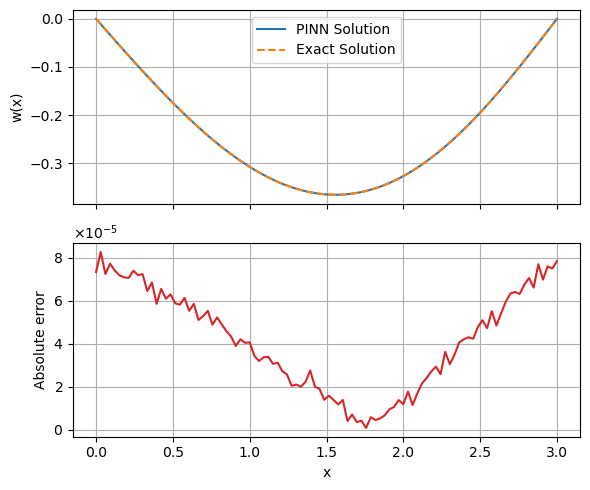

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(x, u_pred, label="PINN Solution")
ax1.plot(x, u_exact, label="Exact Solution", linestyle="dashed")
ax1.set(ylabel='w(x)')
ax1.legend()
ax1.grid()

ax2.plot(x, abs_error, 'tab:red')
ax2.set(xlabel='x', ylabel='Absolute error')
ax2.grid()

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Defines when to switch to scientific notation

ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [172]:
log_file = "pinn_experiments.csv"

# Define the parameters to log
experiment_data = {
    "learning_rate": [adam_lr, lbfgs_lr],
    "num_epochs": epochs,
    "num_points": n_points,
    "hidden_layers": layers[1:-1],
    "weight_pde": w_pde,
    "weight_bc": w_bc,
    "final_loss": "{:.3e}".format(final_loss),
    "max_abs_error": "{:.3e}".format(max_error),
    "L2_error": "{:.3e}".format(u_error),
    "train_time": "{:.3f}".format(trainning_time)
}

# Check if file exists to write the header only once
file_exists = os.path.isfile(log_file)

with open(log_file, mode="a", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=experiment_data.keys())
    
    # Write the header if it's a new file
    if not file_exists:
        writer.writeheader()
    
    # Write experiment data
    writer.writerow(experiment_data)

print("Experiment logged successfully!")

Experiment logged successfully!
